<a href="https://colab.research.google.com/github/cdcmx2020a/group_a_twitter/blob/master/lesson2_gnews_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas unidecode wordcloud sklearn nltk tqdm

     |████████████████████████████████| 245kB 3.4MB/s 


In [82]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# progress bars 
from tqdm.notebook import tqdm

# text manipulation
from unidecode import unidecode
import re

# visualization
from wordcloud import WordCloud

# topic modeling, etc
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [49]:
def get_cases_df():
    df = pd.read_csv(
        'https://raw.githubusercontent.com/cdcmx2020a/group_a_twitter/master/covid_data/cases_mexico_transformed.csv'
    )
    df = df[['date', 'cases']].groupby('date', as_index=False)['cases'].sum()
    return df 


def get_news_df(lang):
    #lang options are 'en' or 'es'
    def _xform_text(x):
        if x != x:
            return ''
        else:
            return unidecode(str(x).strip('"'))
    manifest = pd.read_csv(
        f'https://raw.githubusercontent.com/cdcmx2020a/group_a_twitter/master/gnews_raw_{lang}/manifest.txt',
        header=None,
        names=['jsons'])['jsons'].tolist()
    dfs = []
    for f in tqdm(manifest):
        if 'manifest' in f:
            continue
        try:
            df = pd.read_csv(f'https://github.com/cdcmx2020a/group_a_twitter/blob/master/gnews_raw_{lang}/{f}?raw=true', names=['full_text'])
        except:
            continue 
        date = int(f.split('.')[0])
        df['date'] = date * np.ones(df.shape[0], dtype=int)
        df['full_text'] = df['full_text'].apply(_xform_text)
        dfs.append(df)
    df = pd.concat(dfs, axis=0) 
    return df 


def get_twitter_df():
    manifest = pd.read_csv(
        'https://raw.githubusercontent.com/cdcmx2020a/group_a_twitter/master/processed_json/manifest.txt',
        header=None,
        names=['jsons'])['jsons'].tolist()
    df = pd.concat(
        [pd.read_json(f'https://github.com/cdcmx2020a/group_a_twitter/blob/master/processed_json/{f}?raw=true', lines=True) 
            for f in tqdm(manifest)],
        axis=0
    )
    # df = df.query('date > 60')
    return df 


def reweight_twitter(df):
    n_days = {
        1: 31, 2: 29, 3: 31, 4: 30, 5: 31, 6: 30, 7:31
    }
    n_tweets = {
        1: 1.2e7, 2: 3.2e7, 3:4.0e7, 4: 3.1e7, 5: 3.2e7,
        6: 1.12e8, 7: 7.1e7 
    }
    month_weights = {'date':[], 'weight': [], 'ones': []}
    last = -1
    for m,days in tqdm(list(n_days.items())):
        start = last + 1 
        end = last + days 
        # print(m, start, end)
        last = end 
        n_recorded = df.query(f'date>={start} & date<={end}').shape[0]
        if n_recorded == 0:
            weight = 1
        else:
            weight = n_tweets[m] / n_recorded 
            # weight = int(1e6) / n_recorded
        month_weights['date'] += list(range(start, end+1))
        month_weights['weight'] += [weight] * days 
        month_weights['ones'] += [1] * days 
    
    df_weights = pd.DataFrame(month_weights)
    
    if 'weight' in df.columns:
        df = df.drop(columns=['weight', 'ones'])
    df_weighted = df.merge(df_weights, on='date', how='inner').sort_values(by='date')

    df_weighted = df_weighted.drop_duplicates(['full_text', 'date'], keep='first')

    return df_weighted


def get_stopword_list(lang):
    # lang options are 'english' or 'spanish'
    df = pd.read_csv(f'https://raw.githubusercontent.com/Alir3z4/stop-words/master/{lang}.txt', names='a')
    return df['a'].tolist()

In [50]:
# load two dataframes: cases per day in and Google News articles 
# keywords: 'covid', 'coronavirus', 'pandemia', 'cubrebocas', 'tapabocas', 
#           'cuarentena', 'distanciamiento social', 'quédate en casa',
#           'sars cov-2
cases = get_cases_df()
news = get_news_df(lang='en')
display(news['full_text'].head(5).tolist())

,full_text,date
0,How patients can start--and stick with--key li...,0
1,Fire destroys house near downtown Raleigh; fir...,0
2,Watch Now: Governor Tony Evers updates Wiscons...,0
3,Column One: My New Year's resolution to be mor...,0
4,Beauty Bar: Dior Capture Totale DreamSkin 1-Mi...,0


In [61]:
def remove_after_hyphen(txt):
    return txt.split(' - ')[0]
    # more robust solution using regular expressions:
    # return re.sub(r' - .*', '', txt)
news['full_text_no_hyphen'] = news['full_text'].apply(remove_after_hyphen)

## Topic Modeling

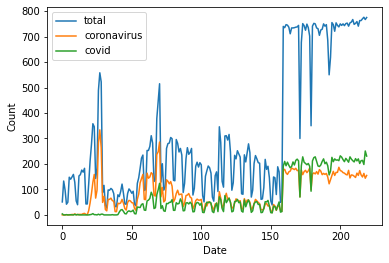

In [51]:
# count number of times a word appears in a headline over time

def count_word(df, word=None):
    if word is None:
        count = np.ones(df.shape[0], dtype=float)
    else:
        # count number of times word appears in each tweet 
        count = df['full_text'].apply(lambda x: x.lower().count(word))
    tmp_df = pd.DataFrame({
        'date': df['date'],
        'count': count
    })
    tmp_df = tmp_df.groupby('date', as_index=False)['count'].sum().sort_values(by='date')
    return tmp_df

total = count_word(news)
count_coronavirus = count_word(news, 'coronavirus')
count_covid = count_word(news, 'covid')

plt.plot(total['date'], total['count'], label='total')
plt.plot(count_coronavirus['date'], count_coronavirus['count'], label='coronavirus')
plt.plot(count_covid['date'], count_covid['count'], label='covid')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

## Non-negative Matrix Factorization

Let's say we have a vocabulary of words $V$. Each document (headline, article, tweet, etc) can be represented by the number of times the word shows up.

For example, if my vocabulary is: 

`[I, really, like, coffee, tea]` 

then the sentence "I really really like coffee" is represented by 

`[1, 2, 1, 1, 0]`

We can represent a corpus of documents as a giant matrix $A$ of size $m\times n$. where $m$ is the number of documents and $n=|V|$. This matrix is very large and sparse (many zeros) because most words occur rarely. 

Non-negative matrix factorization: split $A$ into two smaller matrices $W$ and $H$ with parameter $k \ll n$:
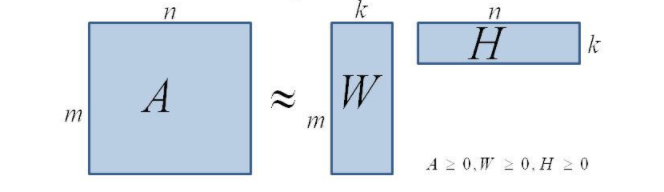

$k$ is the number of topics. $H$ defines the topics. Specifically, $H_{ij}$ is a number ($\geq 0$) that tells us how much word $i$ matters to topic $j$. 

Similarly, $W_{ij}$ tells us how much topic $j$ matters to document $i$. These numbers must all be positive, which is why we use *non-negative* factorization.



In [45]:
class Config(dict):
    '''
    Just a helper class to define configuration of topic modeling tasks
    '''
    def __init__(self, *args, **kwargs):
        super().__init__(self, *args, **kwargs)
        for k,v in self.items():
            setattr(self, k, v)


def build_topic_model(data, feature_extractor, nmf):
    # data: list (or column) of N documents
    # feature_extractor: CountVectorizer, TfIdfVectorizer, etc
    # nmf: NMF
    # returns top 20 words for each topic; embedding documents by topic

    # get feature representation of each sample. 
    # see https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text 
    # for documentation. doc_features is a matrix of size (N, vocab_size)
    doc_features = feature_extractor.fit_transform(data)

    # fit the NMF model to the features. docs_by_topic is a matrix of size (N, ???)
    docs_by_topic = nmf.fit_transform(doc_features)

    # get a mapping of feature index -> vocabulary term. then use it to get the terms
    # that correspond to each topic 
    feature_names = feature_extractor.get_feature_names()
    topics = []
    for idx, topic in enumerate(nmf.components_):
        topics.append(
            [feature_names[i] for i in topic.argsort()[:-11:-1]]
        )
    return topics, docs_by_topic

In [88]:
nmf = NMF(n_components=20)
cv = CountVectorizer()
#cv = CountVectorizer(stop_words=get_stopword_list(lang='english'))
topics, docs_by_topic = build_topic_model(news['full_text_no_hyphen'], cv, nmf)
display(['; '.join(t) for t in topics])

['the; are; how; world; has; will; us; from; best; that',
 'covid; 19; update; health; testing; patients; from; cases; vaccine; test',
 'to; how; be; wear; due; it; need; get; help; your',
 'in; cases; county; china; public; us; place; study; first; time',
 'social; distancing; rules; while; at; measures; guidelines; will; not; during',
 'at; home; stay; order; orders; during; county; gov; may; after',
 'coronavirus; updates; outbreak; china; from; us; says; cases; update; live',
 'of; sars; cov; out; spread; study; state; health; risk; number',
 'for; positive; test; sars; cov; tests; testing; day; fda; days',
 'and; how; more; sars; are; cov; it; other; health; goats',
 'pandemic; during; amid; how; health; will; global; could; has; are',
 'quarantine; from; after; during; self; 14; day; travel; travelers; rules',
 'new; cases; deaths; reports; county; more; reported; york; record; additional',
 'mask; face; wearing; wear; your; mandate; you; not; county; order',
 'masks; face; are; 

## Term frequency-Inverse document frequency (tf-idf)

In some cases, better document representation comes from tf-idf. There are various schemes of tf-idf. Here, I will explain the simplest one. In practice, we will use the logarithmic scaling explained in [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). The overall principle is the same.

Term frequency of term $t$ in document $D$:
$$
\mathrm{tf}(t,D) = \text{number of times $t$ appears in $D$} 
$$

Document frequency of each term: 
$$\mathrm{df}(t) = \text{the number of documents $t$ appears in}
$$
Inverse document frequency:
$$\mathrm{idf}(t) = \frac{1}{\mathrm{df}(t)}$$

Finally, the tf-idf feature:
$$\text{tf-idf}(t, D) = \mathrm{tf}(t,D) \cdot \mathrm{idf}(t)$$

In [77]:
nmf = NMF(n_components=20)
tfidf = TfidfVectorizer(stop_words=get_stopword_list(lang='english'))
#tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words=get_stopword_list(lang='english'))
topics, docs_by_topic = build_topic_model(news['full_text_no_hyphen'], tfidf, nmf)
display(['; '.join(t) for t in topics])

['covid; 19; patients; vaccine; risk; report; study; disease; testing; response',
 'social; distancing; rules; measures; guidelines; practice; time; summer; isolation; school',
 'coronavirus; vaccine; surge; california; trump; report; confirmed; disease; crisis; fight',
 'pandemic; global; trump; post; 1918; flu; time; prepare; change; lessons',
 'mask; wear; mandate; requirement; city; rules; mandates; requirements; ordinance; statewide',
 'quarantine; 14; travel; day; travelers; rules; isolation; list; life; days',
 'masks; wear; mandatory; require; required; public; surgical; n95; medical; requiring',
 'stay; california; governor; safe; extended; extends; residents; businesses; lifted; stocks',
 'sars; cov; vaccine; study; antibody; fda; infection; antibodies; emergency; authorization',
 'health; public; mental; officials; care; experts; workers; department; emergency; impact',
 'update; 2020; daily; july; roundup; june; april; ama; maine; video',
 'deaths; reports; 000; day; report

## n-grams

The phrase "stay at home policy" can be represented as:
```
['stay', 'at', 'home', 'policy'] -> [1, 1, 1, 1]
```
However, the phrase "at home stay policy" is also represented by the same numbers. To encode the importance of ordering, we can look at n-grams.

For example, the possible 3-grams for a vocabulary of four words is:
```
[['stay', 'at', 'home'],
 ['stay', 'at', 'policy'],
 ['stay', 'home', 'policy'],...]
 ```
The vocabulary size blows up exponentially, but we can now tell the difference between "stay at home policy" and "at home stay policy".

## $R^2$ score

Let's say we have a continuous variable $y$ and an estimate of that variable $\hat{y}$. For example, $y$ can be the true temperature on a given day and $\hat{y}$ can be what the news predicts the day before.

### How well does $\hat{y}$ estimate $y$?

The $R^2$ score is a measure of *explained variance*. 

Variance of $y$ is a measure of the spread of $y$ around the mean ($\bar{y}$):
$$
\mathrm{var}(y) = \frac{1}{N} \sum_{i=1}^N (y-\bar{y})^2
$$

If $\hat{y}$ is a good estimate of $y$, then $\hat{y} - y$ is close to zero. In that case, $\mathrm{var}(y - \hat{y})$ is also small. But how small is small?

We compare $\mathrm{var}(y - \hat{y})$ to $\mathrm{var}(y)$:
$$
R^2 = 1 - \frac{\mathrm{var}(y - \hat{y})}{\mathrm{var}(y)}
$$
Possible situations: 
 - Perfect predictor: $R^2 = 1$
 - Purely random predictor $R^2 \rightarrow -\infty$ 
 - $\hat{y} = \bar{y}$: $R^2 = 0$


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


'R^2 = 0.27378'

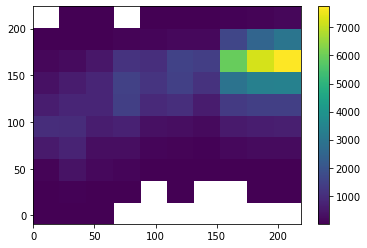

In [87]:
# predict the date of a headline from its topic representation 
date = news['date'].values
lr = MLPRegressor(
        activation='tanh', learning_rate_init=0.01, max_iter=500, learning_rate='adaptive'
    ).fit(docs_by_topic, news['date'].values)
#lr = LinearRegression().fit(docs_by_topic, date)
date_pred = lr.predict(docs_by_topic)
print(f'R^2 = {r2_score(date, date_pred):.5f}')
plt.hist2d(news['date'].values, date_pred, cmin=0.5)
plt.colorbar()
plt.show()